### Build CNN Conditional GAN to generate synthetic cifar 10 data
Traditional Conditional GAN label embedding: embed labels to both generator and discriminator

In [67]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms, datasets
from torch import optim as optim

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [69]:
training_parameters = {
    "n_epochs": 100,
    "batch_size": 100,
}
data_loader = torch.utils.data.DataLoader(
  
datasets.MNIST('./', train=True, download=True,
                         transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(
                             (0.5,), (0.5,))
                         ])),
batch_size=training_parameters["batch_size"], shuffle=True)

torch.Size([100, 1, 28, 28])


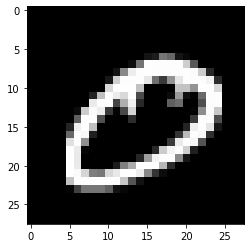

In [70]:
%matplotlib inline 
from matplotlib import pyplot as plt

for x,_ in data_loader:
    print(x.shape)
    plt.imshow(x.numpy()[0][0], cmap='gray')
    break

In [71]:
class Generator1(nn.Module):
    def __init__(self):
        super(Generator1, self).__init__()
        image_size = 28
        latent_dim = 100
        output_channels = 1
        self.init_size = image_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))
        self.label_embedding = nn.Embedding(10, 10)
        self.l2 = nn.Linear(10, self.init_size * self.init_size)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(129),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(129, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, output_channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, labels):
# #         print(z.shape)
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size) # bh, 128, 8, 8
# #         print(out.shape)
        
        li = self.label_embedding(labels)
# #         print(li.shape)
        li = self.l2(li)
# #         print(li.shape)
        li = li.view(labels.shape[0], 1, self.init_size, self.init_size)
# #         print(li.shape)
        out = torch.cat([out, li], 1)
# #         print(out.shape)
        
        img = self.conv_blocks(out)
# #         print(img.shape)
        return img
'''
z shape torch.Size([100, 100])
z shape after view torch.Size([100, 128, 7, 7])
label embedding shape torch.Size([100, 10])
label embedding after l2 torch.Size([100, 49])
label embedding after view torch.Size([100, 1, 7, 7])
concatenate z and label embedding torch.Size([100, 129, 7, 7])
after convolution layers torch.Size([100, 1, 28, 28])
'''

class Generator2(nn.Module):
    def __init__(self):
        super(Generator2, self).__init__()
        image_size = 28
        latent_dim = 100
        number_classes = 10
        output_channels = 1
        self.init_size = image_size // 4
        self.l1 = nn.Sequential(nn.Linear(110, 128 * self.init_size ** 2))
        self.label_embedding = nn.Embedding(10, 10)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, output_channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, labels):
        li = self.label_embedding(labels)
        out = torch.cat([z, li], 1)
#         print(f'li shape {li.shape}, z shape {z.shape}, out shape {out.shape}') # bh, 10    bh, 100    bh, 110
        out = self.l1(out)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size) # bh, 128, 8, 8
        img = self.conv_blocks(out)
        
        return img
    
class Generator3(nn.Module):
    def __init__(self):
        super(Generator3, self).__init__()
        image_size = 28
        latent_dim = 100
        output_channels = 1
        self.init_size = image_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))
        self.label_embedding = nn.Embedding(10, 10)
        self.l2 = nn.Linear(10, self.init_size * self.init_size)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, output_channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, labels):
# #         print(z.shape)
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size) # bh, 128, 7, 7
# #         print(out.shape)
        
        li = self.label_embedding(labels)
# #         print(li.shape)
        li = self.l2(li)
# #         print(li.shape)
        li = li.view(labels.shape[0], 1, self.init_size, self.init_size) #bh, 1, 7, 7
# #         print(li.shape)
#         out = torch.cat([out, li], 1)
#         print(out[0].shape)　#128, 7, 7
        out[0] + li
#         print(out.shape) #bh, 128, 7, 7
        
        img = self.conv_blocks(out)
# #         print(img.shape)
        return img


In [72]:
class Discriminator1(nn.Module):
    def __init__(self):
        super(Discriminator1, self).__init__()
        self.image_size = 28
        self.output_channels = 1 + 1
        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(self.output_channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )
        self.label_embedding = nn.Embedding(10, 10)
        self.l1 = nn.Linear(10, self.image_size * self.image_size)

        # The height and width of downsampled image
        ds_size = self.image_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(512, 1), nn.Sigmoid())
        

    def forward(self, img, labels):
#         print(img.shape)
        li = self.label_embedding(labels)
        li = self.l1(li)
#         print(li.shape)
        li = li.view(labels.shape[0], 1, self.image_size, self.image_size)
#         print(li.shape)
        img = torch.cat([img, li], 1)
#         print(img.shape)
        
        out = self.model(img)
#         print(out.shape)
        out = out.view(out.shape[0], -1)
#         print(out.shape)
        validity = self.adv_layer(out)
#         print(validity)

        return validity
    
'''
image shape torch.Size([100, 1, 28, 28])
label embedding after l1 shape torch.Size([100, 784])
label embedding after reshape torch.Size([100, 1, 28, 28])
concatenate image and label embedding torch.Size([100, 2, 28, 28])
feature map size after convolution layers torch.Size([100, 128, 2, 2])
feature map to dense layer torch.Size([100, 512])
'''

# output two number
class Discriminator2(nn.Module):
    def __init__(self):
        super(Discriminator2, self).__init__()
        self.image_size = 28
        self.output_channels = 1 + 1
        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(self.output_channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )
        self.label_embedding = nn.Embedding(10, 10)
        self.l1 = nn.Linear(10, self.image_size * self.image_size)

        # The height and width of downsampled image
        ds_size = self.image_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(512, 1), nn.Sigmoid())
        
#         self.conv1 = nn.Conv2d(curr_dim, 1, kernel_size=3, stride=1, padding=1, bias=False)
#         self.conv2 = nn.Conv2d(curr_dim, c_dim, kernel_size=kernel_size, bias=False)
        

    def forward(self, img, labels):
#         print(img.shape)
        li = self.label_embedding(labels)
        li = self.l1(li)
#         print(li.shape)
        li = li.view(labels.shape[0], 1, self.image_size, self.image_size)
#         print(li.shape)
        img = torch.cat([img, li], 1)
#         print(img.shape)
        
        out = self.model(img)
#         print(out.shape)
        out = out.view(out.shape[0], -1)
#         print(out.shape)
        validity = self.adv_layer(out)
#         print(validity)
        h = self.main(x)
    
#         out_src = self.conv1(h)
#         out_cls = self.conv2(h)
#         return out_src, out_cls.view(out_cls.size(0), out_cls.size(1))
        return validity

In [73]:
discriminator1 = Discriminator1()
generator1 = Generator1()
generator2 = Generator2()
generator3 = Generator3()
discriminator1.to(device)
generator1.to(device)
generator2.to(device)
generator3.to(device)

Generator3(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
  )
  (label_embedding): Embedding(10, 10)
  (l2): Linear(in_features=10, out_features=49, bias=True)
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [74]:
noise = torch.randn(100,100).to(device)
fake_labels = torch.randint(0, 10, (100,)).to(device)
generated_data = generator(noise, fake_labels)

In [75]:
discriminator_output_for_generated_data = discriminator(generated_data.detach(), fake_labels).view(100)

In [76]:
def train(generator, discriminator, data_loader, model_name='model_name'):
    n_epochs = 100
    batch_size = 100
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
    generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

    loss = nn.BCELoss()
    for epoch_idx in range(n_epochs):
        G_loss = []
        D_loss = []
        for batch_idx, data_input in enumerate(data_loader):


            noise = torch.randn(batch_size,100).to(device)
            fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
            generated_data = generator(noise, fake_labels)


            # Discriminator
            true_data = data_input[0].to(device)
            digit_labels = data_input[1].to(device) # batch_size
            true_labels = torch.ones(batch_size).to(device)

            discriminator_optimizer.zero_grad()

            discriminator_output_for_true_data = discriminator(true_data, digit_labels).view(batch_size)
            true_discriminator_loss = loss(discriminator_output_for_true_data, true_labels)

            discriminator_output_for_generated_data = discriminator(generated_data.detach(), fake_labels).view(batch_size)
            generator_discriminator_loss = loss(
                discriminator_output_for_generated_data, torch.zeros(batch_size).to(device)
            )
            discriminator_loss = (
                true_discriminator_loss + generator_discriminator_loss
            ) / 2

            discriminator_loss.backward()
            discriminator_optimizer.step()

            D_loss.append(discriminator_loss.data.item())


            # Generator

            generator_optimizer.zero_grad()
            # It's a choice to generate the data again
            generated_data = generator(noise, fake_labels)
            discriminator_output_on_generated_data = discriminator(generated_data, fake_labels).view(batch_size)
            generator_loss = loss(discriminator_output_on_generated_data, true_labels)
            generator_loss.backward()
            generator_optimizer.step()

            G_loss.append(generator_loss.data.item())
            if ((batch_idx + 1)% 500 == 0 and (epoch_idx + 1)%10 == 0):
                print("Training Steps Completed: ", batch_idx)

                with torch.no_grad():
                    noise = torch.randn(batch_size,100).to(device)
                    fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
                    generated_data = generator(noise, fake_labels).cpu().view(batch_size, 28, 28)
                    for x in generated_data:
                        print(fake_labels[0].item())
                        plt.imshow(x.detach().numpy(), interpolation='nearest',cmap='gray')
                        plt.show()
                        break


        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
                (epoch_idx), n_epochs, torch.mean(torch.FloatTensor(D_loss)), torch.mean(torch.FloatTensor(G_loss))))
        
        torch.save(generator, f'./{model_name}.pt')

In [77]:
#load model and generate 0 - 9 images
def draw_images(model_name):
    generator = torch.load(model_name)
    with torch.no_grad():
        noise = torch.randn(10,100).to(device)
        labels = torch.IntTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to(device)
#         labels = torch.range(0, 9)
        generated_data = generator(noise, labels).cpu().view(10, 28, 28)

    fig, axs = plt.subplots(1, 10, figsize=(20,2))
    for i in range(10):
        axs[i].imshow(generated_data[i].detach().numpy(), interpolation='nearest',cmap='gray')
    fig.savefig(f'{model_name}_syn.pdf')

[0/100]: loss_d: 0.650, loss_g: 0.778
[1/100]: loss_d: 0.415, loss_g: 1.444
[2/100]: loss_d: 0.464, loss_g: 1.386
[3/100]: loss_d: 0.557, loss_g: 1.193
[4/100]: loss_d: 0.562, loss_g: 1.142
[5/100]: loss_d: 0.554, loss_g: 1.113
[6/100]: loss_d: 0.536, loss_g: 1.203
[7/100]: loss_d: 0.495, loss_g: 1.271
[8/100]: loss_d: 0.465, loss_g: 1.375
Training Steps Completed:  499
4


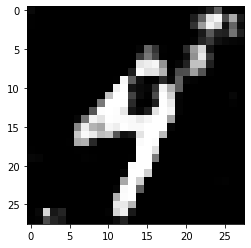

[9/100]: loss_d: 0.438, loss_g: 1.498
[10/100]: loss_d: 0.441, loss_g: 1.516
[11/100]: loss_d: 0.478, loss_g: 1.403
[12/100]: loss_d: 0.495, loss_g: 1.351
[13/100]: loss_d: 0.498, loss_g: 1.407
[14/100]: loss_d: 0.530, loss_g: 1.293
[15/100]: loss_d: 0.526, loss_g: 1.227
[16/100]: loss_d: 0.538, loss_g: 1.220
[17/100]: loss_d: 0.540, loss_g: 1.221
[18/100]: loss_d: 0.537, loss_g: 1.171
Training Steps Completed:  499
6


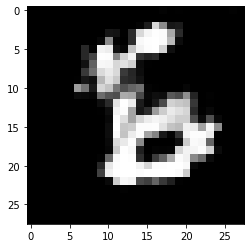

[19/100]: loss_d: 0.576, loss_g: 1.186
[20/100]: loss_d: 0.583, loss_g: 1.131
[21/100]: loss_d: 0.596, loss_g: 1.069
[22/100]: loss_d: 0.599, loss_g: 1.038
[23/100]: loss_d: 0.604, loss_g: 1.045
[24/100]: loss_d: 0.614, loss_g: 1.036
[25/100]: loss_d: 0.600, loss_g: 1.022
[26/100]: loss_d: 0.599, loss_g: 1.007
[27/100]: loss_d: 0.607, loss_g: 0.998
[28/100]: loss_d: 0.611, loss_g: 1.006
Training Steps Completed:  499
4


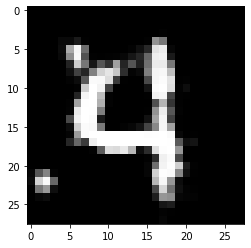

[29/100]: loss_d: 0.597, loss_g: 0.996
[30/100]: loss_d: 0.602, loss_g: 0.995
[31/100]: loss_d: 0.599, loss_g: 1.006
[32/100]: loss_d: 0.600, loss_g: 1.022
[33/100]: loss_d: 0.601, loss_g: 1.059
[34/100]: loss_d: 0.606, loss_g: 1.010
[35/100]: loss_d: 0.619, loss_g: 0.977
[36/100]: loss_d: 0.613, loss_g: 0.986
[37/100]: loss_d: 0.615, loss_g: 0.982
[38/100]: loss_d: 0.607, loss_g: 0.982
Training Steps Completed:  499
4


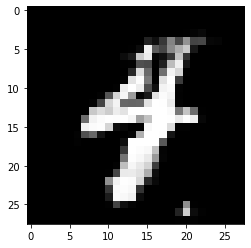

[39/100]: loss_d: 0.597, loss_g: 0.968
[40/100]: loss_d: 0.612, loss_g: 0.976
[41/100]: loss_d: 0.615, loss_g: 0.968
[42/100]: loss_d: 0.618, loss_g: 0.978
[43/100]: loss_d: 0.594, loss_g: 1.000
[44/100]: loss_d: 0.618, loss_g: 0.959
[45/100]: loss_d: 0.612, loss_g: 0.965
[46/100]: loss_d: 0.602, loss_g: 0.995
[47/100]: loss_d: 0.607, loss_g: 0.958
[48/100]: loss_d: 0.596, loss_g: 0.986
Training Steps Completed:  499
0


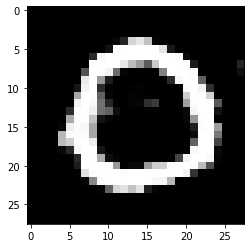

[49/100]: loss_d: 0.607, loss_g: 0.967
[50/100]: loss_d: 0.598, loss_g: 0.975
[51/100]: loss_d: 0.613, loss_g: 0.981
[52/100]: loss_d: 0.610, loss_g: 0.978
[53/100]: loss_d: 0.603, loss_g: 0.993
[54/100]: loss_d: 0.607, loss_g: 0.966
[55/100]: loss_d: 0.610, loss_g: 0.952
[56/100]: loss_d: 0.598, loss_g: 0.989
[57/100]: loss_d: 0.619, loss_g: 0.944
[58/100]: loss_d: 0.604, loss_g: 0.969
Training Steps Completed:  499
2


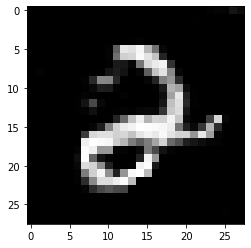

[59/100]: loss_d: 0.598, loss_g: 0.952
[60/100]: loss_d: 0.615, loss_g: 0.976
[61/100]: loss_d: 0.603, loss_g: 0.977
[62/100]: loss_d: 0.612, loss_g: 0.967
[63/100]: loss_d: 0.601, loss_g: 0.997
[64/100]: loss_d: 0.618, loss_g: 0.959
[65/100]: loss_d: 0.610, loss_g: 0.970
[66/100]: loss_d: 0.602, loss_g: 0.946
[67/100]: loss_d: 0.595, loss_g: 0.971
[68/100]: loss_d: 0.612, loss_g: 0.979
Training Steps Completed:  499
4


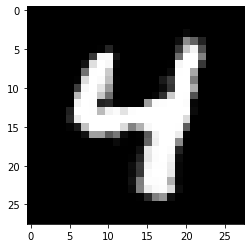

[69/100]: loss_d: 0.602, loss_g: 0.988
[70/100]: loss_d: 0.600, loss_g: 0.971
[71/100]: loss_d: 0.610, loss_g: 0.953
[72/100]: loss_d: 0.608, loss_g: 0.967
[73/100]: loss_d: 0.605, loss_g: 0.970
[74/100]: loss_d: 0.599, loss_g: 0.981
[75/100]: loss_d: 0.606, loss_g: 0.948
[76/100]: loss_d: 0.592, loss_g: 0.970
[77/100]: loss_d: 0.607, loss_g: 0.979
[78/100]: loss_d: 0.603, loss_g: 0.971
Training Steps Completed:  499
3


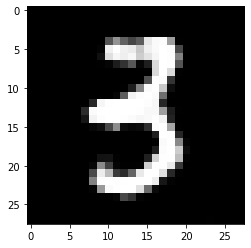

[79/100]: loss_d: 0.613, loss_g: 0.964
[80/100]: loss_d: 0.614, loss_g: 0.939
[81/100]: loss_d: 0.607, loss_g: 0.981
[82/100]: loss_d: 0.615, loss_g: 0.935
[83/100]: loss_d: 0.602, loss_g: 0.949
[84/100]: loss_d: 0.600, loss_g: 0.972
[85/100]: loss_d: 0.613, loss_g: 0.964
[86/100]: loss_d: 0.612, loss_g: 0.955
[87/100]: loss_d: 0.602, loss_g: 0.974
[88/100]: loss_d: 0.598, loss_g: 1.006
Training Steps Completed:  499
5


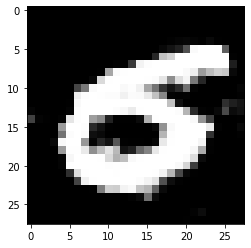

[89/100]: loss_d: 0.595, loss_g: 1.009
[90/100]: loss_d: 0.590, loss_g: 0.984
[91/100]: loss_d: 0.611, loss_g: 0.999
[92/100]: loss_d: 0.603, loss_g: 0.971
[93/100]: loss_d: 0.609, loss_g: 0.999
[94/100]: loss_d: 0.620, loss_g: 0.969
[95/100]: loss_d: 0.599, loss_g: 0.979
[96/100]: loss_d: 0.607, loss_g: 0.962
[97/100]: loss_d: 0.604, loss_g: 1.023
[98/100]: loss_d: 0.587, loss_g: 0.994
Training Steps Completed:  499
1


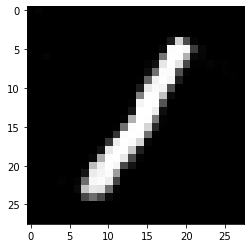

[99/100]: loss_d: 0.599, loss_g: 1.026


In [78]:
discriminator1 = Discriminator1()
generator1 = Generator1()
discriminator1.to(device) 
generator1.to(device)
train(generator1, discriminator1, data_loader, model_name='g1_d1_cnn')

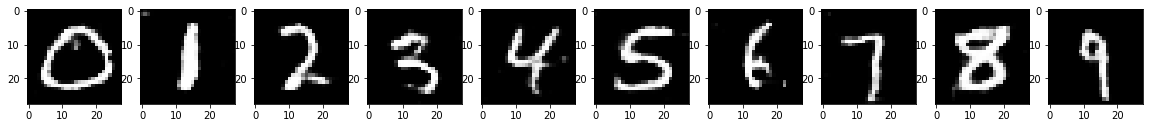

In [79]:
draw_images('g1_d1_cnn.pt')

[0/100]: loss_d: 0.682, loss_g: 0.731
[1/100]: loss_d: 0.683, loss_g: 0.724
[2/100]: loss_d: 0.662, loss_g: 0.778
[3/100]: loss_d: 0.689, loss_g: 0.742
[4/100]: loss_d: 0.676, loss_g: 0.738
[5/100]: loss_d: 0.671, loss_g: 0.756
[6/100]: loss_d: 0.675, loss_g: 0.768
[7/100]: loss_d: 0.670, loss_g: 0.767
[8/100]: loss_d: 0.659, loss_g: 0.787
Training Steps Completed:  499
2


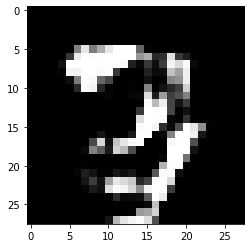

[9/100]: loss_d: 0.639, loss_g: 0.840
[10/100]: loss_d: 0.662, loss_g: 0.817
[11/100]: loss_d: 0.607, loss_g: 0.923
[12/100]: loss_d: 0.583, loss_g: 1.018
[13/100]: loss_d: 0.536, loss_g: 1.125
[14/100]: loss_d: 0.545, loss_g: 1.171
[15/100]: loss_d: 0.476, loss_g: 1.390
[16/100]: loss_d: 0.449, loss_g: 1.515
[17/100]: loss_d: 0.528, loss_g: 1.383
[18/100]: loss_d: 0.416, loss_g: 1.575
Training Steps Completed:  499
6


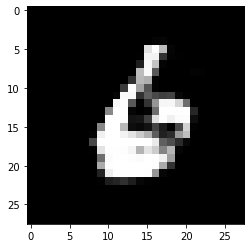

[19/100]: loss_d: 0.400, loss_g: 1.767
[20/100]: loss_d: 0.413, loss_g: 1.832
[21/100]: loss_d: 0.350, loss_g: 2.004
[22/100]: loss_d: 0.294, loss_g: 2.307
[23/100]: loss_d: 0.442, loss_g: 1.895
[24/100]: loss_d: 0.338, loss_g: 2.341
[25/100]: loss_d: 0.379, loss_g: 2.084
[26/100]: loss_d: 0.328, loss_g: 2.151
[27/100]: loss_d: 0.251, loss_g: 2.461
[28/100]: loss_d: 0.293, loss_g: 2.502
Training Steps Completed:  499
1


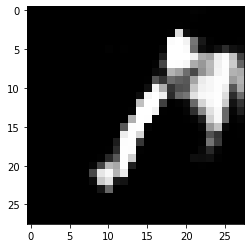

[29/100]: loss_d: 0.262, loss_g: 2.646
[30/100]: loss_d: 0.302, loss_g: 2.480
[31/100]: loss_d: 0.158, loss_g: 3.410
[32/100]: loss_d: 0.280, loss_g: 2.543
[33/100]: loss_d: 0.216, loss_g: 3.170
[34/100]: loss_d: 0.176, loss_g: 2.793
[35/100]: loss_d: 0.094, loss_g: 3.798
[36/100]: loss_d: 0.257, loss_g: 2.701
[37/100]: loss_d: 0.388, loss_g: 2.104
[38/100]: loss_d: 0.470, loss_g: 1.741
Training Steps Completed:  499
5


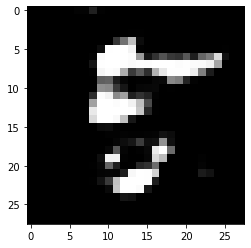

[39/100]: loss_d: 0.437, loss_g: 1.808
[40/100]: loss_d: 0.489, loss_g: 1.630
[41/100]: loss_d: 0.465, loss_g: 1.620
[42/100]: loss_d: 0.384, loss_g: 1.817
[43/100]: loss_d: 0.440, loss_g: 1.673
[44/100]: loss_d: 0.476, loss_g: 1.607
[45/100]: loss_d: 0.502, loss_g: 1.623
[46/100]: loss_d: 0.421, loss_g: 1.929
[47/100]: loss_d: 0.450, loss_g: 1.731
[48/100]: loss_d: 0.398, loss_g: 1.908
Training Steps Completed:  499
1


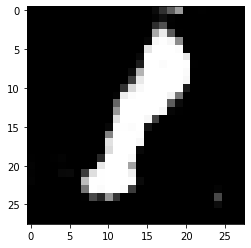

[49/100]: loss_d: 0.475, loss_g: 1.813
[50/100]: loss_d: 0.446, loss_g: 1.891
[51/100]: loss_d: 0.438, loss_g: 1.844
[52/100]: loss_d: 0.407, loss_g: 1.954
[53/100]: loss_d: 0.324, loss_g: 2.189
[54/100]: loss_d: 0.238, loss_g: 2.627
[55/100]: loss_d: 0.349, loss_g: 2.126
[56/100]: loss_d: 0.224, loss_g: 2.487
[57/100]: loss_d: 0.292, loss_g: 2.211
[58/100]: loss_d: 0.206, loss_g: 3.136
Training Steps Completed:  499
4


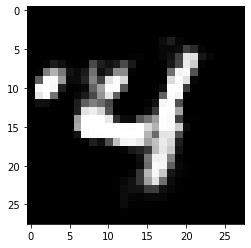

[59/100]: loss_d: 0.322, loss_g: 2.338
[60/100]: loss_d: 0.196, loss_g: 2.576
[61/100]: loss_d: 0.144, loss_g: 3.124
[62/100]: loss_d: 0.176, loss_g: 2.951
[63/100]: loss_d: 0.177, loss_g: 2.989
[64/100]: loss_d: 0.189, loss_g: 2.863
[65/100]: loss_d: 0.337, loss_g: 2.300
[66/100]: loss_d: 0.338, loss_g: 2.089
[67/100]: loss_d: 0.391, loss_g: 2.028
[68/100]: loss_d: 0.302, loss_g: 2.293
Training Steps Completed:  499
2


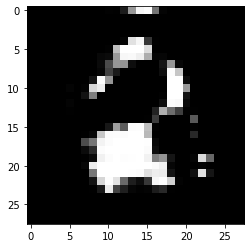

[69/100]: loss_d: 0.387, loss_g: 2.026
[70/100]: loss_d: 0.381, loss_g: 2.327
[71/100]: loss_d: 0.336, loss_g: 2.214
[72/100]: loss_d: 0.297, loss_g: 2.312
[73/100]: loss_d: 0.171, loss_g: 3.079
[74/100]: loss_d: 0.301, loss_g: 2.403
[75/100]: loss_d: 0.396, loss_g: 1.827
[76/100]: loss_d: 0.397, loss_g: 1.860
[77/100]: loss_d: 0.494, loss_g: 1.605
[78/100]: loss_d: 0.440, loss_g: 1.778
Training Steps Completed:  499
6


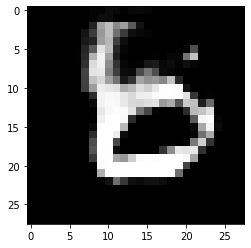

[79/100]: loss_d: 0.415, loss_g: 1.825
[80/100]: loss_d: 0.488, loss_g: 1.681
[81/100]: loss_d: 0.300, loss_g: 2.037
[82/100]: loss_d: 0.374, loss_g: 1.950
[83/100]: loss_d: 0.330, loss_g: 2.140
[84/100]: loss_d: 0.485, loss_g: 1.615
[85/100]: loss_d: 0.430, loss_g: 1.678
[86/100]: loss_d: 0.439, loss_g: 1.666
[87/100]: loss_d: 0.400, loss_g: 1.810
[88/100]: loss_d: 0.422, loss_g: 1.715
Training Steps Completed:  499
4


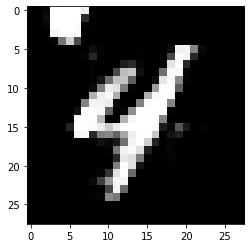

[89/100]: loss_d: 0.298, loss_g: 2.256
[90/100]: loss_d: 0.290, loss_g: 2.284
[91/100]: loss_d: 0.273, loss_g: 2.412
[92/100]: loss_d: 0.289, loss_g: 2.244
[93/100]: loss_d: 0.272, loss_g: 2.363
[94/100]: loss_d: 0.443, loss_g: 1.776
[95/100]: loss_d: 0.356, loss_g: 2.001
[96/100]: loss_d: 0.364, loss_g: 1.892
[97/100]: loss_d: 0.434, loss_g: 1.632
[98/100]: loss_d: 0.451, loss_g: 1.726
Training Steps Completed:  499
3


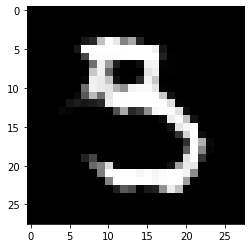

[99/100]: loss_d: 0.431, loss_g: 1.778


In [80]:
discriminator1 = Discriminator1()
generator2 = Generator2()
discriminator1.to(device) 
generator2.to(device)
train(generator2, discriminator1, data_loader, model_name='g2_d1_cnn')

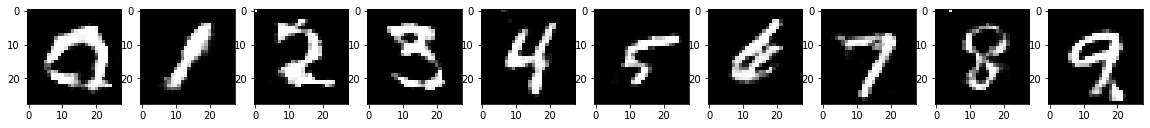

In [81]:
draw_images('g2_d1_cnn.pt')

[0/100]: loss_d: 0.674, loss_g: 0.728
[1/100]: loss_d: 0.322, loss_g: 2.042
[2/100]: loss_d: 0.019, loss_g: 5.100
[3/100]: loss_d: 0.006, loss_g: 6.846
[4/100]: loss_d: 0.003, loss_g: 7.742
[5/100]: loss_d: 0.001, loss_g: 8.644
[6/100]: loss_d: 0.001, loss_g: 9.301
[7/100]: loss_d: 0.000, loss_g: 9.709
[8/100]: loss_d: 0.000, loss_g: 10.579
Training Steps Completed:  499
6


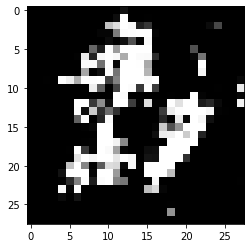

[9/100]: loss_d: 0.000, loss_g: 11.182
[10/100]: loss_d: 0.000, loss_g: 11.385
[11/100]: loss_d: 0.000, loss_g: 12.420
[12/100]: loss_d: 0.000, loss_g: 12.695
[13/100]: loss_d: 0.000, loss_g: 13.107
[14/100]: loss_d: 0.000, loss_g: 13.532
[15/100]: loss_d: 0.000, loss_g: 13.915
[16/100]: loss_d: 0.000, loss_g: 14.458
[17/100]: loss_d: 0.000, loss_g: 14.709
[18/100]: loss_d: 0.002, loss_g: 14.096
Training Steps Completed:  499
9


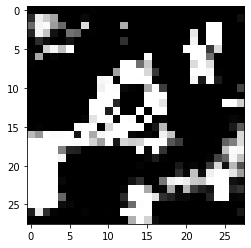

[19/100]: loss_d: 0.000, loss_g: 14.911
[20/100]: loss_d: 0.000, loss_g: 14.994
[21/100]: loss_d: 0.000, loss_g: 14.946
[22/100]: loss_d: 0.000, loss_g: 15.797
[23/100]: loss_d: 0.000, loss_g: 14.377
[24/100]: loss_d: 0.000, loss_g: 15.273
[25/100]: loss_d: 0.000, loss_g: 16.286
[26/100]: loss_d: 0.000, loss_g: 16.804
[27/100]: loss_d: 0.000, loss_g: 15.695
[28/100]: loss_d: 0.000, loss_g: 16.251
Training Steps Completed:  499
9


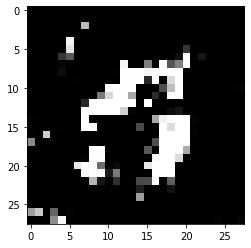

[29/100]: loss_d: 0.000, loss_g: 16.542
[30/100]: loss_d: 0.000, loss_g: 17.221
[31/100]: loss_d: 0.000, loss_g: 17.467
[32/100]: loss_d: 0.000, loss_g: 17.518
[33/100]: loss_d: 0.000, loss_g: 17.072
[34/100]: loss_d: 0.000, loss_g: 17.593
[35/100]: loss_d: 0.000, loss_g: 18.277
[36/100]: loss_d: 0.000, loss_g: 18.545
[37/100]: loss_d: 0.000, loss_g: 18.350
[38/100]: loss_d: 0.000, loss_g: 17.665
Training Steps Completed:  499
9


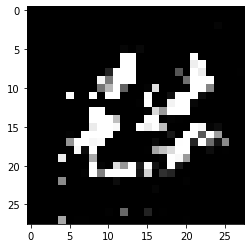

[39/100]: loss_d: 0.000, loss_g: 17.325
[40/100]: loss_d: 0.000, loss_g: 19.387
[41/100]: loss_d: 0.000, loss_g: 18.526
[42/100]: loss_d: 0.000, loss_g: 18.973
[43/100]: loss_d: 0.000, loss_g: 19.103
[44/100]: loss_d: 0.000, loss_g: 19.592
[45/100]: loss_d: 0.000, loss_g: 21.026
[46/100]: loss_d: 0.000, loss_g: 18.662
[47/100]: loss_d: 0.000, loss_g: 20.103
[48/100]: loss_d: 0.000, loss_g: 19.324
Training Steps Completed:  499
8


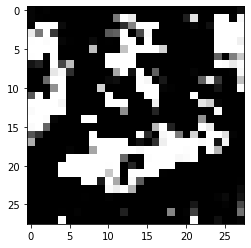

[49/100]: loss_d: 0.000, loss_g: 23.054
[50/100]: loss_d: 0.000, loss_g: 19.419
[51/100]: loss_d: 0.000, loss_g: 20.475
[52/100]: loss_d: 0.000, loss_g: 21.510
[53/100]: loss_d: 0.000, loss_g: 20.801
[54/100]: loss_d: 0.000, loss_g: 20.557
[55/100]: loss_d: 0.000, loss_g: 21.449
[56/100]: loss_d: 0.000, loss_g: 21.574
[57/100]: loss_d: 0.000, loss_g: 20.122
[58/100]: loss_d: 0.000, loss_g: 20.511
Training Steps Completed:  499
0


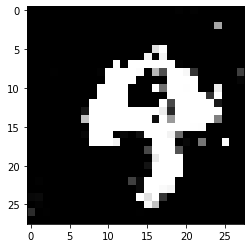

[59/100]: loss_d: 0.000, loss_g: 22.000
[60/100]: loss_d: 0.000, loss_g: 20.896
[61/100]: loss_d: 0.000, loss_g: 20.554
[62/100]: loss_d: 0.000, loss_g: 22.699
[63/100]: loss_d: 0.000, loss_g: 21.703
[64/100]: loss_d: 0.000, loss_g: 21.715
[65/100]: loss_d: 0.000, loss_g: 22.771
[66/100]: loss_d: 0.000, loss_g: 23.495
[67/100]: loss_d: 0.000, loss_g: 24.508
[68/100]: loss_d: 0.000, loss_g: 26.008
Training Steps Completed:  499
0


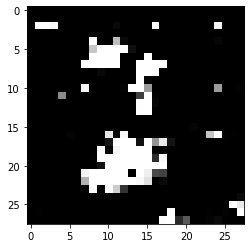

[69/100]: loss_d: 0.000, loss_g: 27.567
[70/100]: loss_d: 0.000, loss_g: 28.374
[71/100]: loss_d: 0.000, loss_g: 37.194
[72/100]: loss_d: 0.000, loss_g: 30.450
[73/100]: loss_d: 0.000, loss_g: 34.293
[74/100]: loss_d: 0.000, loss_g: 37.098
[75/100]: loss_d: 0.000, loss_g: 27.095
[76/100]: loss_d: 0.000, loss_g: 20.206
[77/100]: loss_d: 0.000, loss_g: 22.104
[78/100]: loss_d: 0.000, loss_g: 24.348
Training Steps Completed:  499
7


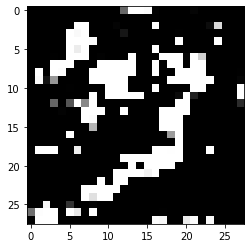

[79/100]: loss_d: 0.000, loss_g: 22.664
[80/100]: loss_d: 0.000, loss_g: 21.475
[81/100]: loss_d: 0.000, loss_g: 22.282
[82/100]: loss_d: 0.000, loss_g: 22.016
[83/100]: loss_d: 0.000, loss_g: 22.663
[84/100]: loss_d: 0.000, loss_g: 23.790
[85/100]: loss_d: 0.000, loss_g: 25.888
[86/100]: loss_d: 0.000, loss_g: 23.785
[87/100]: loss_d: 0.000, loss_g: 22.803
[88/100]: loss_d: 0.000, loss_g: 23.013
Training Steps Completed:  499
2


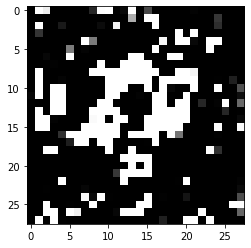

[89/100]: loss_d: 0.000, loss_g: 24.378
[90/100]: loss_d: 0.000, loss_g: 24.141
[91/100]: loss_d: 0.000, loss_g: 23.931
[92/100]: loss_d: 0.000, loss_g: 25.491
[93/100]: loss_d: 0.000, loss_g: 32.335
[94/100]: loss_d: 0.000, loss_g: 43.188
[95/100]: loss_d: 0.000, loss_g: 42.704
[96/100]: loss_d: 0.000, loss_g: 42.338
[97/100]: loss_d: 0.000, loss_g: 40.962
[98/100]: loss_d: 0.000, loss_g: 36.000
Training Steps Completed:  499
4


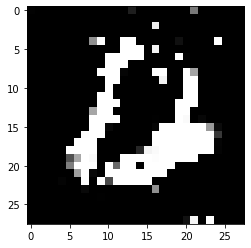

[99/100]: loss_d: 0.000, loss_g: 24.773


In [82]:
discriminator1 = Discriminator1()
generator3 = Generator3()
discriminator1.to(device) 
generator3.to(device)
train(generator3, discriminator1, data_loader, model_name='g3_d1_cnn')

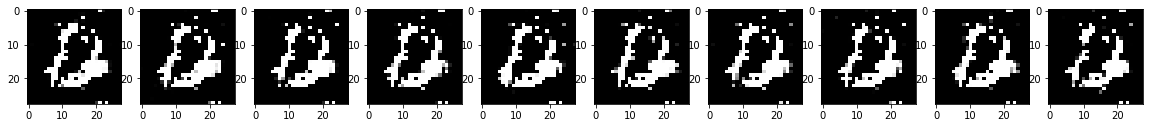

In [83]:
draw_images('g3_d1_cnn.pt')